In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import ExtraTreesClassifier,RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import optuna
from sklearn.model_selection import cross_val_score
from scipy.stats import randint
from scipy.stats import uniform
from sklearn.ensemble import VotingClassifier,StackingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, log_loss, brier_score_loss,
    confusion_matrix, classification_report,
    confusion_matrix, roc_curve, auc,
    brier_score_loss
)
import warnings

pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_columns',None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)
warnings.filterwarnings("ignore")

C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df_login=pd.read_csv("../EDA_transform/data/login_transform.csv",dtype={'vopenid':'object'})
df_purchase=pd.read_csv("../EDA_transform/data/purchase_transform.csv",dtype={'vopenid':'object'})
df_login.shape,df_purchase.shape

((59569, 17), (25625, 9))

In [3]:
df_login.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59569 entries, 0 to 59568
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   vopenid                59569 non-null  object 
 1   last_update_time       59569 non-null  object 
 2   num_day_login          59569 non-null  int64  
 3   avg_login_per_day      59569 non-null  float64
 4   avg_between_login      59569 non-null  float64
 5   streak_login           59569 non-null  int64  
 6   last_since_from_login  59569 non-null  int64  
 7   popular_time_login     59569 non-null  int64  
 8   gold_std_login         59569 non-null  float64
 9   diamond_std_login      59569 non-null  float64
 10  silkcoin_std_login     59569 non-null  float64
 11  gold_slope_login       59569 non-null  float64
 12  diamond_slope_login    59569 non-null  float64
 13  silkcoin_slope_login   59569 non-null  float64
 14  powerpoint_last_login  59569 non-null  int64  
 15  le

In [4]:
df_purchase.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25625 entries, 0 to 25624
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   vopenid                   25625 non-null  object 
 1   last_update_time          25625 non-null  object 
 2   num_purchase              25625 non-null  int64  
 3   total_purchase            25625 non-null  float64
 4   count_purchase_per_day    25625 non-null  float64
 5   std_amount_purchase       25625 non-null  float64
 6   max_purchase              25625 non-null  float64
 7   days_since_last_purchase  25625 non-null  int64  
 8   num_product_buyed         25625 non-null  int64  
dtypes: float64(4), int64(3), object(2)
memory usage: 1.8+ MB


In [5]:
df_purchase_rename = df_purchase.rename(columns={'last_update_time': 'last_update_time_purchase'}) # rename to prepare to merged
df_merged = df_login.merge(
    df_purchase_rename.drop(columns=['last_update_time_purchase']),
    on='vopenid',
    how='left'
)
df_merged['has_purchase'] = (~df_merged['total_purchase'].isnull()).astype(int)
df_merged.shape

(59569, 25)

In [6]:
del df_login
del df_purchase

In [7]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59569 entries, 0 to 59568
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   vopenid                   59569 non-null  object 
 1   last_update_time          59569 non-null  object 
 2   num_day_login             59569 non-null  int64  
 3   avg_login_per_day         59569 non-null  float64
 4   avg_between_login         59569 non-null  float64
 5   streak_login              59569 non-null  int64  
 6   last_since_from_login     59569 non-null  int64  
 7   popular_time_login        59569 non-null  int64  
 8   gold_std_login            59569 non-null  float64
 9   diamond_std_login         59569 non-null  float64
 10  silkcoin_std_login        59569 non-null  float64
 11  gold_slope_login          59569 non-null  float64
 12  diamond_slope_login       59569 non-null  float64
 13  silkcoin_slope_login      59569 non-null  float64
 14  powerp

In [8]:
df_merged['last_update_time'] = pd.to_datetime(df_merged['last_update_time'])
df_merged['last_update_time'].dtypes

datetime64[ns, UTC]

In [9]:
df_merged['last_update_time'].min(),df_merged['last_update_time'].max()

(Timestamp('2025-05-14 17:00:00+0000', tz='UTC'),
 Timestamp('2025-05-15 13:36:07+0000', tz='UTC'))

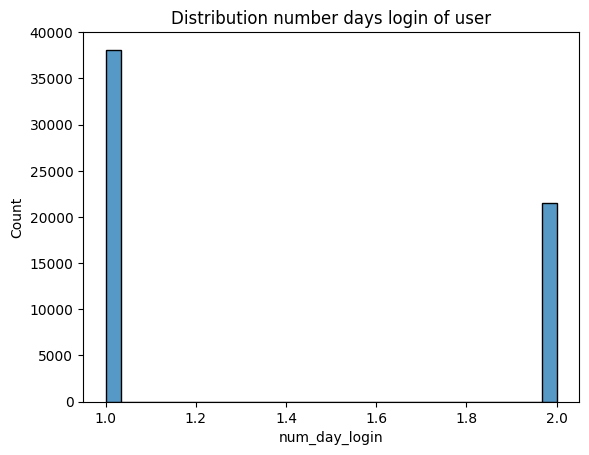

In [10]:
sns.histplot(df_merged['num_day_login'], bins=30)
plt.title('Distribution number days login of user')
plt.show()

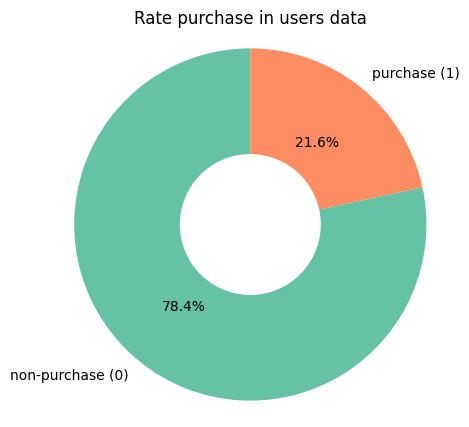

In [11]:
counts = df_merged['has_purchase'].value_counts().sort_index()
labels = ['non-purchase (0)', 'purchase (1)']

colors = sns.color_palette('Set2', n_colors=2)

plt.figure(figsize=(5,5))
plt.pie(counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, wedgeprops=dict(width=0.6))
plt.title('Rate purchase in users data', fontsize=12)
plt.axis('equal')
plt.show()

In [12]:
df_merged['last_update_time'].min(),df_merged['last_update_time'].max()

(Timestamp('2025-05-14 17:00:00+0000', tz='UTC'),
 Timestamp('2025-05-15 13:36:07+0000', tz='UTC'))

In [13]:
now = pd.Timestamp('2025-05-28 12:00:00', tz='UTC')
df_merged['days_since_last_login'] = (now - df_merged['last_update_time']).dt.days
df_merged['churn'] = (df_merged['days_since_last_login'] >= 7).astype(int)

df_merged[['vopenid','last_update_time','has_purchase','churn']].head(10)

,vopenid,last_update_time,has_purchase,churn
0,1000,2025-05-15 02:32:35+00:00,0,1
1,1024,2025-05-15 04:48:25+00:00,0,1
2,1025,2025-05-15 02:11:19+00:00,0,1
3,1030,2025-05-15 04:49:49+00:00,0,1
4,1036,2025-05-15 04:15:19+00:00,0,1
5,1050,2025-05-15 08:46:32+00:00,0,1
6,1060,2025-05-15 09:07:06+00:00,0,1
7,1075,2025-05-15 04:44:37+00:00,0,1
8,1078,2025-05-15 04:26:31+00:00,0,1
9,1080,2025-05-15 13:36:02+00:00,0,1


In [14]:
purchase_cols = [
    'num_purchase', 
    'total_purchase',
    'max_purchase',
    'days_since_last_purchase',
    'num_product_buyed',
    'days_since_last_login',
]
df_merged=df_merged.drop(columns=purchase_cols,axis=1)

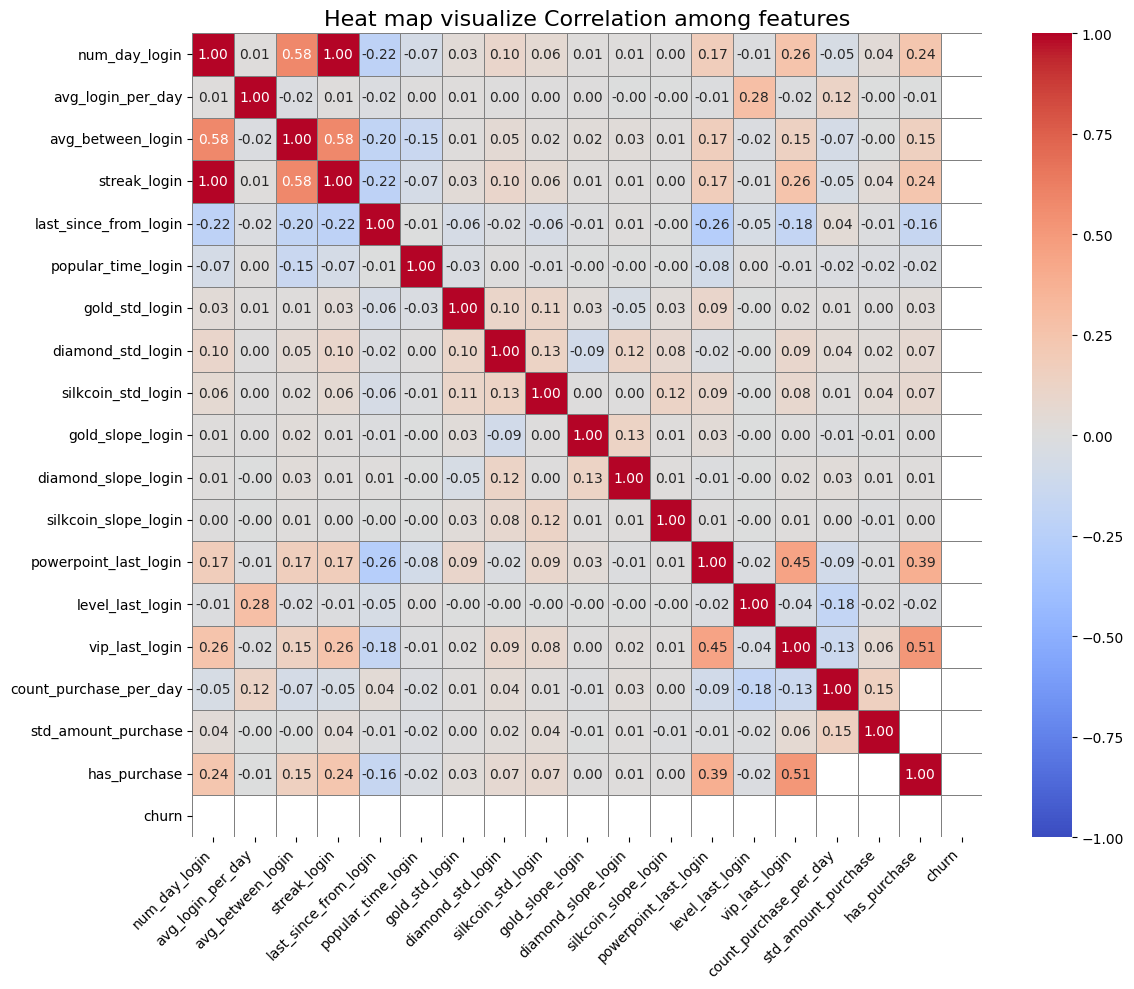

In [15]:
corr_cols = df_merged.drop(columns=['vopenid', 'last_update_time']).columns

corr_matrix = df_merged[corr_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_matrix,
    annot=True,        
    fmt=".2f",
    cmap="coolwarm",    
    vmin=-1,           
    vmax=1,
    center=0,        
    linewidths=0.5,     
    linecolor='gray' 
)

plt.title('Heat map visualize Correlation among features', fontsize=16)
plt.xticks(rotation=45, ha='right') 
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [16]:
corr_matrix = df_merged[corr_cols].corr()
corr_matrix

,num_day_login,avg_login_per_day,avg_between_login,streak_login,last_since_from_login,popular_time_login,gold_std_login,diamond_std_login,silkcoin_std_login,gold_slope_login,diamond_slope_login,silkcoin_slope_login,powerpoint_last_login,level_last_login,vip_last_login,count_purchase_per_day,std_amount_purchase,has_purchase,churn
num_day_login,1.00,0.01,0.58,1.00,-0.22,-0.07,0.03,0.10,0.06,0.01,0.01,0.00,0.17,-0.01,0.26,-0.05,0.04,0.24,NaN
avg_login_per_day,0.01,1.00,-0.02,0.01,-0.02,0.00,0.01,0.00,0.00,0.00,-0.00,-0.00,-0.01,0.28,-0.02,0.12,-0.00,-0.01,NaN
avg_between_login,0.58,-0.02,1.00,0.58,-0.20,-0.15,0.01,0.05,0.02,0.02,0.03,0.01,0.17,-0.02,0.15,-0.07,-0.00,0.15,NaN
streak_login,1.00,0.01,0.58,1.00,-0.22,-0.07,0.03,0.10,0.06,0.01,0.01,0.00,0.17,-0.01,0.26,-0.05,0.04,0.24,NaN
last_since_from_login,-0.22,-0.02,-0.20,-0.22,1.00,-0.01,-0.06,-0.02,-0.06,-0.01,0.01,-0.00,-0.26,-0.05,-0.18,0.04,-0.01,-0.16,NaN
popular_time_login,-0.07,0.00,-0.15,-0.07,-0.01,1.00,-0.03,0.00,-0.01,-0.00,-0.00,-0.00,-0.08,0.00,-0.01,-0.02,-0.02,-0.02,NaN
gold_std_login,0.03,0.01,0.01,0.03,-0.06,-0.03,1.00,0.10,0.11,0.03,-0.05,0.03,0.09,-0.00,0.02,0.01,0.00,0.03,NaN
diamond_std_login,0.10,0.00,0.05,0.10,-0.02,0.00,0.10,1.00,0.13,-0.09,0.12,0.08,-0.02,-0.00,0.09,0.04,0.02,0.07,NaN
silkcoin_std_login,0.06,0.00,0.02,0.06,-0.06,-0.01,0.11,0.13,1.00,0.00,0.00,0.12,0.09,-0.00,0.08,0.01,0.04,0.07,NaN
gold_slope_login,0.01,0.00,0.02,0.01,-0.01,-0.00,0.03,-0.09,0.00,1.00,0.13,0.01,0.03,-0.00,0.00,-0.01,-0.01,0.00,NaN


In [17]:
X=df_merged.drop(columns=['churn','vopenid','last_update_time','last_since_from_login'],axis=1)
y=df_merged['churn']

In [18]:
vopenid_all = df_merged['vopenid']

In [19]:
X_temp, X_train, y_temp, y_train, vopenid_temp, vopenid_train = train_test_split(
    X, y, vopenid_all,
    test_size=0.8, shuffle=False
)

X_test, X_val, y_test, y_val, vopenid_test, vopenid_val = train_test_split(
    X_temp, y_temp, vopenid_temp,
    test_size=0.5, shuffle=False
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape, vopenid_train.shape, vopenid_test.shape

((47656, 17), (5956, 17), (47656,), (5956,), (47656,), (5956,))

In [20]:
scaler = StandardScaler()
scaler.fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled  = scaler.transform(X_test)

In [21]:
def objective(trial):
    params = {
        'C': trial.suggest_float('C', 0.001, 10.0, log=True),
        'penalty': trial.suggest_categorical('penalty', ['l1', 'l2']),
        'solver': trial.suggest_categorical('solver', ['liblinear', 'saga']),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42
    }
    model = LogisticRegression(**params)
    score = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best AUC:", study.best_value)
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

[I 2025-06-17 16:30:27,680] A new study created in memory with name: no-name-97c2bad6-ba44-426f-b3f7-93d6bd960cfa
[W 2025-06-17 16:30:27,744] Trial 0 failed with parameters: {'C': 0.121257749493874, 'penalty': 'l1', 'solver': 'liblinear', 'class_weight': None} because of the following error: ValueError('\nAll the 5 fits failed.\nIt is very likely that your model is misconfigured.\nYou can try to debug the error by setting error_score=\'raise\'.\n\nBelow are more details about the failures:\n--------------------------------------------------------------------------------\n5 fits failed with the following error:\nTraceback (most recent call last):\n  File "C:\\Users\\GOSU.GOSU-TT-ZION1\\AppData\\Roaming\\Python\\Python312\\site-packages\\sklearn\\model_selection\\_validation.py", line 866, in _fit_and_score\n    estimator.fit(X_train, y_train, **fit_params)\n  File "C:\\Users\\GOSU.GOSU-TT-ZION1\\AppData\\Roaming\\Python\\Python312\\site-packages\\sklearn\\base.py", line 1389, in wrapper

ValueError: 
All the 5 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\sklearn\model_selection\_validation.py", line 866, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\sklearn\linear_model\_logistic.py", line 1222, in fit
    X, y = validate_data(
           ^^^^^^^^^^^^^^
  File "C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py", line 2961, in validate_data
    X, y = check_X_y(X, y, **check_params)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py", line 1370, in check_X_y
    X = check_array(
        ^^^^^^^^^^^^
  File "C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py", line 1107, in check_array
    _assert_all_finite(
  File "C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py", line 120, in _assert_all_finite
    _assert_all_finite_element_wise(
  File "C:\Users\GOSU.GOSU-TT-ZION1\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py", line 169, in _assert_all_finite_element_wise
    raise ValueError(msg_err)
ValueError: Input X contains NaN.
LogisticRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values


In [ ]:
best_params_lr = study.best_params
best_params_lr.update({
    'random_state': 42,
    'n_jobs': -1
})
lr_model = LogisticRegression(**best_params_lr)
lr_model.fit(X_train_scaled, y_train)

In [ ]:
y_test_pred  = lr_model.predict(X_test_scaled)
y_test_proba = lr_model.predict_proba(X_test_scaled)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),
        'max_depth': trial.suggest_int('max_depth', 10, 30),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
        'random_state': 42,
        'n_jobs': -1
    }
    
    model = ExtraTreesClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

In [ ]:
best_params_et = study.best_params
best_params_et.update({
    'random_state': 42,
    'n_jobs': -1
})
et_model = ExtraTreesClassifier(**best_params_et)
et_model.fit(X_train, y_train)

In [ ]:
y_test_pred  = et_model.predict(X_test)
y_test_proba = et_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 300, 500),            
        'max_depth': trial.suggest_int('max_depth', 10, 30),                     
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 20),     
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 20),      
        'max_features': trial.suggest_categorical('max_features', ['sqrt', 'log2', None, 0.5, 0.8]),
        'bootstrap': trial.suggest_categorical('bootstrap', [True, False]),
        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample']),
        'random_state': 42,
        'n_jobs': -1
    }

    model = RandomForestClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

In [ ]:
best_params_rf = study.best_params
best_params_rf.update({
    'random_state': 42,
    'n_jobs': -1
})
rf_model = RandomForestClassifier(**best_params_rf)
rf_model.fit(X_train, y_train)

In [ ]:
y_test_pred  = rf_model.predict(X_test)
y_test_proba = rf_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
def objective(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'gamma': trial.suggest_float('gamma', 0, 8),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 12),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.5, 1.0),
        'subsample': trial.suggest_float('subsample', 0.7, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 0.5),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 0.5),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 2, 5, 10]),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'tree_method': 'hist',
        'use_label_encoder': False,
        'eval_metric': 'logloss',
        'random_state': 42
    }

    model = XGBClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best values", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

In [ ]:
best_params_xgb = study.best_params
best_params_xgb.update({
    'use_label_encoder': False,
    'eval_metric': 'logloss',
    'random_state': 42,
    'tree_method': 'hist'
})
xgb_model = XGBClassifier(**best_params_xgb)
xgb_model.fit(X_train, y_train)

In [ ]:
y_test_pred  = xgb_model.predict(X_test)
y_test_proba = xgb_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
def objective(trial):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.4),
        'max_depth': trial.suggest_int('max_depth', 3, 12),
        'num_leaves': trial.suggest_int('num_leaves', 15, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 5, 100),
        'min_split_gain': trial.suggest_float('min_split_gain', 0.0, 1.0),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_categorical('scale_pos_weight', [1, 2, 5, 10]),
        'random_state': 42,
        'n_jobs': -1
    }

    model = LGBMClassifier(**params)
    score = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc').mean()
    return score

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100)

print("Best value:", study.best_value)
print("Best params:")
for k, v in study.best_params.items():
    print(f"  - {k}: {v}")

In [ ]:
best_params_lgbm = study.best_params
best_params_lgbm.update({
    'random_state': 42,
    'n_jobs': -1
})
lgbm_model = LGBMClassifier(**best_params_lgbm)
lgbm_model.fit(X_train, y_train)

In [ ]:
y_test_pred  = lgbm_model.predict(X_test)
y_test_proba = lgbm_model.predict_proba(X_test)[:, 1]

print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba):.4f}")
print(f"Log loss: {log_loss(y_test, y_test_proba):.4f}")
print(f"Brier score: {brier_score_loss(y_test, y_test_proba):.4f}")
print("\nConfusion matrix:")
print(confusion_matrix(y_test, y_test_pred))
print("\nClassification report:")
print(classification_report(y_test, y_test_pred))

In [ ]:
lr_model = make_pipeline(
    StandardScaler(),
    LogisticRegression(**best_params_lr)
)
et_model = ExtraTreesClassifier(**best_params_et)
rf_model = RandomForestClassifier(**best_params_rf)
xgb_model = XGBClassifier(**best_params_xgb)
lgbm_model = LGBMClassifier(**best_params_lgbm)

In [ ]:
voting_model = VotingClassifier(
    estimators=[
        ('lr', lr_model),
        ('et',et_model),
        ('rf', rf_model),
        #('svc',svc_model),
        ('xgb', xgb_model),
        ('lgbm', lgbm_model),
    ],
    voting='soft' 
)

voting_model.fit(X_train, y_train)  

In [ ]:
y_test_proba_voting = voting_model.predict_proba(X_test)[:, 1]
y_test_pred_voting  = voting_model.predict(X_test)

In [ ]:
print(f"Accuracy: {accuracy_score(y_test, y_test_pred_voting):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred_voting):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred_voting):.4f}")
print(f"F1-score: {f1_score(y_test, y_test_pred_voting):.4f}")
print(f"AUC-ROC: {roc_auc_score(y_test, y_test_proba_voting):.4f}")
print(f"Log Loss: {log_loss(y_test, y_test_proba_voting):.4f}")
print(f"Brier Score: {brier_score_loss(y_test, y_test_proba_voting):.4f}")
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_test_pred_voting))
print("\nClassification Report:")
print(classification_report(y_test, y_test_pred_voting))